## 1. Import thư viện và thiết lập

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ast import literal_eval
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Import library tự viết
from cluster_library import DataCleaner

# Thiết lập
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 80)

# Random seed
np.random.seed(42)

## 2. Load dữ liệu

In [2]:
DATA_DIR = Path("../data/processed")

# Load dữ liệu đã làm sạch
df_clean = pd.read_csv(DATA_DIR / "cleaned_uk_data.csv")
print(f"Loaded cleaned data: {df_clean.shape}")
print(f"Columns: {list(df_clean.columns)}")

# Load luật đã chọn (từ notebook trước)
rules_file = DATA_DIR / "rules_apriori_top200_selected.csv"
if not rules_file.exists():
    # Fallback: sử dụng file filtered
    rules_file = DATA_DIR / "rules_apriori_filtered.csv"
    
rules = pd.read_csv(rules_file)
print(f"\nLoaded rules: {len(rules)} rules")
print(f"Rule columns: {list(rules.columns)}")

Loaded cleaned data: (485123, 11)
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalPrice', 'DayOfWeek', 'HourOfDay']

Loaded rules: 175 rules
Rule columns: ['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift', 'representativity', 'leverage', 'conviction', 'zhangs_metric', 'jaccard', 'certainty', 'kulczynski', 'antecedents_str', 'consequents_str', 'rule_str']


C:\Users\binhn\AppData\Local\Temp\ipykernel_14844\3306047173.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean = pd.read_csv(DATA_DIR / "cleaned_uk_data.csv")


## 3. Xử lý dữ liệu khách hàng

Chuẩn bị Customer × Item matrix (boolean)

In [3]:
# Chuẩn hóa CustomerID
df_clean['CustomerID'] = (
    df_clean['CustomerID']
    .astype(str)
    .str.replace('.0', '', regex=False)
    .str.zfill(6)
)

# Tạo Customer × Item matrix
customer_item_qty = (
    df_clean.groupby(['CustomerID', 'Description'])['Quantity']
    .sum()
    .unstack(fill_value=0)
)

# Boolean matrix: khách hàng đã từng mua item hay chưa
customer_item_bool = (customer_item_qty >= 1)

print(f"Customer × Item matrix shape: {customer_item_bool.shape}")
print(f"Number of customers: {len(customer_item_bool)}")
print(f"Number of unique items: {len(customer_item_bool.columns)}")

Customer × Item matrix shape: (3921, 4007)
Number of customers: 3921
Number of unique items: 4007


## 4. Tính RFM cho khách hàng

RFM sẽ được sử dụng trong các biến thể nâng cao

In [4]:
# Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Tạo cột TotalPrice
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Ngày tham chiếu (1 ngày sau ngày giao dịch cuối cùng)
reference_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# Tính RFM
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})

print("RFM Statistics:")
print(rfm.describe())
print(f"\nRFM shape: {rfm.shape}")

RFM Statistics:
           Recency    Frequency      Monetary
count  3921.000000  3921.000000  3.921000e+03
mean     92.185157     4.596021  2.301765e+03
std      99.531817    23.013506  2.839137e+04
min       1.000000     1.000000  3.750000e+00
25%      18.000000     1.000000  3.003600e+02
50%      51.000000     2.000000  6.527400e+02
75%     143.000000     5.000000  1.578670e+03
max     374.000000  1373.000000  1.716831e+06

RFM shape: (3921, 3)


## 5. Lọc luật (Optional)

Thử nghiệm: Lọc luật theo độ dài antecedent

In [13]:
def parse_frozenset(fs_str):
    """Parse frozenset string to list of items"""
    try:
        # Nếu đã là frozenset object
        if isinstance(fs_str, frozenset):
            return list(fs_str)
        
        # Nếu là string representation của frozenset
        fs_str = str(fs_str).strip()
        
        # Sử dụng literal_eval để parse
        if 'frozenset' in fs_str:
            parsed = literal_eval(fs_str)
            if isinstance(parsed, frozenset):
                return list(parsed)
            elif isinstance(parsed, (list, tuple)):
                return list(parsed)
        
        # Fallback: split by comma
        if ',' in fs_str:
            items = [item.strip() for item in fs_str.split(',') if item.strip()]
            return items
        
        # Single item
        if fs_str and fs_str != 'nan':
            return [fs_str]
        
        return []
    except Exception as e:
        print(f"Warning: Failed to parse '{fs_str}': {e}")
        return []

def parse_antecedents_str(ant_str):
    """Parse antecedents_str column (comma-separated items)"""
    if pd.isna(ant_str):
        return []
    items = [item.strip() for item in str(ant_str).split(',') if item.strip()]
    return items

# Quyết định: Sử dụng cột antecedents_str thay vì antecedents
# vì nó đã được format sẵn dạng string dễ parse
print("=== Parsing antecedents ===")

# Tính độ dài antecedent từ cột antecedents_str
if 'antecedents_str' in rules.columns:
    print("Using antecedents_str column (comma-separated)")
    rules['antecedent_length'] = rules['antecedents_str'].apply(
        lambda x: len(parse_antecedents_str(x))
    )
    # Test
    print("\nTest parsing:")
    for idx in range(min(3, len(rules))):
        ant_str = rules.iloc[idx]['antecedents_str']
        parsed = parse_antecedents_str(ant_str)
        print(f"  Row {idx}: '{ant_str}' -> {parsed} (length={len(parsed)})")
else:
    print("Using antecedents column (frozenset)")
    rules['antecedent_length'] = rules['antecedents'].apply(
        lambda x: len(parse_frozenset(x))
    )

print("\nPhân bố độ dài antecedent:")
print(rules['antecedent_length'].value_counts().sort_index())

# Thiết lập ngưỡng lọc
MIN_ANTECEDENT_LENGTH = 1  # Có thể thay đổi thành 2 để loại luật đơn giản

print(f"\n=== Cấu hình lọc luật ===")
print(f"Min antecedent length: {MIN_ANTECEDENT_LENGTH}")

# Lọc luật
rules_filtered = rules[rules['antecedent_length'] >= MIN_ANTECEDENT_LENGTH].copy()
print(f"\nSố luật ban đầu: {len(rules)}")
print(f"Số luật sau khi lọc: {len(rules_filtered)}")

# Kiểm tra có luật nào sau khi lọc không
if len(rules_filtered) == 0:
    print("\n⚠️ WARNING: Không còn luật nào sau khi lọc!")
    print("Đề xuất: Giảm MIN_ANTECEDENT_LENGTH hoặc kiểm tra lại dữ liệu luật")
else:
    print(f"\n✓ OK: Có {len(rules_filtered)} luật để tạo features")
    print(f"\nSample rules:")
    display(rules_filtered[['antecedents_str', 'consequents_str', 'lift', 'confidence', 'antecedent_length']].head())

# Sử dụng rules_filtered cho các bước tiếp theo
rules_for_features = rules_filtered.copy()

=== Parsing antecedents ===
Using antecedents_str column (comma-separated)

Test parsing:
  Row 0: 'WOODEN HEART CHRISTMAS SCANDINAVIAN' -> ['WOODEN HEART CHRISTMAS SCANDINAVIAN'] (length=1)
  Row 1: 'WOODEN STAR CHRISTMAS SCANDINAVIAN' -> ['WOODEN STAR CHRISTMAS SCANDINAVIAN'] (length=1)
  Row 2: 'GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER ' -> ['GREEN REGENCY TEACUP AND SAUCER', 'ROSES REGENCY TEACUP AND SAUCER'] (length=2)

Phân bố độ dài antecedent:
antecedent_length
1    163
2     12
Name: count, dtype: int64

=== Cấu hình lọc luật ===
Min antecedent length: 1

Số luật ban đầu: 175
Số luật sau khi lọc: 175

✓ OK: Có 175 luật để tạo features

Sample rules:


,antecedents_str,consequents_str,lift,confidence,antecedent_length
0,WOODEN HEART CHRISTMAS SCANDINAVIAN,WOODEN STAR CHRISTMAS SCANDINAVIAN,27.200282,0.722986,1
1,WOODEN STAR CHRISTMAS SCANDINAVIAN,WOODEN HEART CHRISTMAS SCANDINAVIAN,27.200282,0.768267,1
2,"GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER",PINK REGENCY TEACUP AND SAUCER,18.043004,0.702857,2
3,"PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER",GREEN REGENCY TEACUP AND SAUCER,17.455471,0.902752,2
4,"GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY TEACUP AND SAUCER",ROSES REGENCY TEACUP AND SAUCER,16.101399,0.854167,2


## 6. Feature Engineering - Baseline: Binary Rule Features

**Mô tả**:
- Feature vector nhị phân: mỗi chiều tương ứng với một luật
- Giá trị = 1 nếu khách hàng đã mua **tất cả** sản phẩm trong antecedents của luật đó
- Giá trị = 0 nếu không
- **Không có trọng số**
- **Không scale**

In [14]:
def create_binary_rule_features(customer_item_bool, rules_df):
    """
    Tạo binary rule features.
    
    Returns:
        DataFrame: Customer × Rules (binary)
    """
    customers = customer_item_bool.index.tolist()
    n_customers = len(customers)
    n_rules = len(rules_df)
    
    # Khởi tạo feature matrix
    features = np.zeros((n_customers, n_rules), dtype=int)
    
    print(f"Creating binary rule features for {n_customers} customers and {n_rules} rules...")
    
    # Sử dụng cột antecedents_str nếu có
    use_str_col = 'antecedents_str' in rules_df.columns
    
    for rule_idx, (_, rule) in enumerate(rules_df.iterrows()):
        if use_str_col:
            antecedents = parse_antecedents_str(rule['antecedents_str'])
        else:
            antecedents = parse_frozenset(rule['antecedents'])
        
        # Skip if no antecedents
        if not antecedents:
            continue
            
        # Kiểm tra từng khách hàng
        for cust_idx, customer_id in enumerate(customers):
            # Kiểm tra xem khách hàng có mua tất cả antecedent items không
            has_all = all(
                item in customer_item_bool.columns and 
                customer_item_bool.loc[customer_id, item]
                for item in antecedents
            )
            
            if has_all:
                features[cust_idx, rule_idx] = 1
    
    # Tạo DataFrame
    rule_names = [f"rule_{i}" for i in range(n_rules)]
    features_df = pd.DataFrame(features, index=customers, columns=rule_names)
    
    print(f"✓ Created binary features: {features_df.shape}")
    print(f"  Sparsity: {(features == 0).sum() / features.size * 100:.2f}%")
    print(f"  Avg rules per customer: {features.sum(axis=1).mean():.2f}")
    
    return features_df

# Tạo baseline features
features_baseline = create_binary_rule_features(customer_item_bool, rules_for_features)

Creating binary rule features for 3921 customers and 175 rules...
✓ Created binary features: (3921, 175)
  Sparsity: 93.11%
  Avg rules per customer: 12.05


## 7. Feature Engineering - Variant A: Weighted Rule Features

**Mô tả**:
- Tương tự binary nhưng có trọng số
- Trọng số = `lift × confidence` (phản ánh cả độ mạnh quan hệ và độ tin cậy)
- Nếu khách hàng thỏa antecedents, feature value = weight
- Có thể thử các công thức khác:
  - Chỉ `lift`
  - `lift × support`
  - `lift × confidence × support`

In [15]:
def create_weighted_rule_features(customer_item_bool, rules_df, weight_formula='lift_confidence'):
    """
    Tạo weighted rule features.
    
    Args:
        weight_formula: 'lift', 'lift_confidence', 'lift_support', 'lift_conf_supp'
    
    Returns:
        DataFrame: Customer × Rules (weighted)
    """
    customers = customer_item_bool.index.tolist()
    n_customers = len(customers)
    n_rules = len(rules_df)
    
    # Kiểm tra rules_df không rỗng
    if n_rules == 0:
        raise ValueError("rules_df is empty! No rules to create features from.")
    
    # Kiểm tra các cột cần thiết
    required_cols = ['lift', 'confidence', 'support']
    missing_cols = [col for col in required_cols if col not in rules_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns in rules_df: {missing_cols}")
    
    # Tính weights cho mỗi luật
    if weight_formula == 'lift':
        weights = rules_df['lift'].values
    elif weight_formula == 'lift_confidence':
        weights = rules_df['lift'].values * rules_df['confidence'].values
    elif weight_formula == 'lift_support':
        weights = rules_df['lift'].values * rules_df['support'].values
    elif weight_formula == 'lift_conf_supp':
        weights = (rules_df['lift'].values * 
                   rules_df['confidence'].values * 
                   rules_df['support'].values)
    else:
        raise ValueError(f"Unknown weight formula: {weight_formula}")
    
    # Kiểm tra weights không rỗng
    if len(weights) == 0:
        raise ValueError("Weights array is empty!")
    
    print(f"Creating weighted rule features (formula={weight_formula})...")
    print(f"  Number of rules: {n_rules}")
    print(f"  Weight stats: min={weights.min():.4f}, max={weights.max():.4f}, mean={weights.mean():.4f}")
    
    # Khởi tạo feature matrix
    features = np.zeros((n_customers, n_rules), dtype=float)
    
    # Sử dụng cột antecedents_str nếu có
    use_str_col = 'antecedents_str' in rules_df.columns
    
    for rule_idx, (_, rule) in enumerate(rules_df.iterrows()):
        if use_str_col:
            antecedents = parse_antecedents_str(rule['antecedents_str'])
        else:
            antecedents = parse_frozenset(rule['antecedents'])
        
        # Skip if no antecedents
        if not antecedents:
            continue
            
        weight = weights[rule_idx]
        
        for cust_idx, customer_id in enumerate(customers):
            has_all = all(
                item in customer_item_bool.columns and 
                customer_item_bool.loc[customer_id, item]
                for item in antecedents
            )
            
            if has_all:
                features[cust_idx, rule_idx] = weight
    
    # Tạo DataFrame
    rule_names = [f"rule_{i}" for i in range(n_rules)]
    features_df = pd.DataFrame(features, index=customers, columns=rule_names)
    
    print(f"✓ Created weighted features: {features_df.shape}")
    print(f"  Non-zero values: {(features != 0).sum() / features.size * 100:.2f}%")
    print(f"  Avg weighted score per customer: {features.sum(axis=1).mean():.2f}")
    
    return features_df

# Tạo weighted features với công thức lift × confidence
features_weighted = create_weighted_rule_features(
    customer_item_bool, 
    rules_for_features, 
    weight_formula='lift_confidence'
)

Creating weighted rule features (formula=lift_confidence)...
  Number of rules: 175
  Weight stats: min=0.8391, max=20.8971, mean=4.6728
✓ Created weighted features: (3921, 175)
  Non-zero values: 6.89%
  Avg weighted score per customer: 49.82


## 8. Feature Engineering - Variant B: Binary Rules + RFM

**Mô tả**:
- Kết hợp binary rule features với RFM
- RFM được chuẩn hóa (StandardScaler) - **bắt buộc** vì RFM có thang đo khác nhau
- Rule features **không scale** (giữ nguyên 0/1)
- Concatenate: [Binary Rules | RFM_scaled]

In [16]:
def combine_rules_and_rfm(rule_features, rfm_data, scale_rules=False, scale_rfm=True):
    """
    Kết hợp rule features và RFM.
    
    Args:
        rule_features: DataFrame Customer × Rules
        rfm_data: DataFrame Customer × RFM (Recency, Frequency, Monetary)
        scale_rules: bool, có scale rule features không
        scale_rfm: bool, có scale RFM không (khuyến nghị True)
    
    Returns:
        DataFrame: Combined features
    """
    # Đảm bảo cùng customers
    common_customers = rule_features.index.intersection(rfm_data.index)
    print(f"Common customers: {len(common_customers)}")
    
    rule_features_aligned = rule_features.loc[common_customers]
    rfm_aligned = rfm_data.loc[common_customers]
    
    # Scale rule features nếu cần
    if scale_rules:
        scaler_rules = StandardScaler()
        rules_scaled = scaler_rules.fit_transform(rule_features_aligned)
        rules_scaled = pd.DataFrame(
            rules_scaled, 
            index=common_customers, 
            columns=rule_features_aligned.columns
        )
        print("✓ Scaled rule features")
    else:
        rules_scaled = rule_features_aligned
        print("✓ Rule features not scaled (kept original)")
    
    # Scale RFM nếu cần
    if scale_rfm:
        scaler_rfm = StandardScaler()
        rfm_scaled = scaler_rfm.fit_transform(rfm_aligned)
        rfm_scaled = pd.DataFrame(
            rfm_scaled,
            index=common_customers,
            columns=[f'RFM_{col}' for col in rfm_aligned.columns]
        )
        print("✓ Scaled RFM features")
    else:
        rfm_scaled = rfm_aligned.copy()
        rfm_scaled.columns = [f'RFM_{col}' for col in rfm_aligned.columns]
        print("✓ RFM features not scaled")
    
    # Concatenate
    combined = pd.concat([rules_scaled, rfm_scaled], axis=1)
    
    print(f"\n✓ Combined features shape: {combined.shape}")
    print(f"  - Rule features: {rules_scaled.shape[1]}")
    print(f"  - RFM features: {rfm_scaled.shape[1]}")
    
    return combined

# Variant B: Binary + RFM
print("=== VARIANT B: Binary Rules + RFM ===")
features_binary_rfm = combine_rules_and_rfm(
    rule_features=features_baseline,
    rfm_data=rfm,
    scale_rules=False,  # Binary không cần scale
    scale_rfm=True      # RFM cần scale
)

=== VARIANT B: Binary Rules + RFM ===
Common customers: 3921
✓ Rule features not scaled (kept original)
✓ Scaled RFM features

✓ Combined features shape: (3921, 178)
  - Rule features: 175
  - RFM features: 3


## 9. Feature Engineering - Variant C: Weighted Rules + RFM

**Mô tả**:
- Kết hợp weighted rule features với RFM
- **Cả hai phần đều được chuẩn hóa** (vì weighted rules có giá trị lớn)
- Concatenate: [Weighted Rules_scaled | RFM_scaled]

In [17]:
# Variant C: Weighted + RFM
print("=== VARIANT C: Weighted Rules + RFM ===")
features_weighted_rfm = combine_rules_and_rfm(
    rule_features=features_weighted,
    rfm_data=rfm,
    scale_rules=True,   # Weighted cần scale vì giá trị lớn
    scale_rfm=True      # RFM cần scale
)

=== VARIANT C: Weighted Rules + RFM ===
Common customers: 3921
✓ Scaled rule features
✓ Scaled RFM features

✓ Combined features shape: (3921, 178)
  - Rule features: 175
  - RFM features: 3


## 10. Tổng hợp các biến thể

Tạo dictionary chứa tất cả các biến thể để dễ so sánh

In [18]:
# Dictionary chứa tất cả các biến thể
feature_variants = {
    'baseline_binary': {
        'data': features_baseline,
        'description': 'Binary rule features (no weighting, no RFM)',
        'config': {
            'weighting': 'none',
            'rfm': False,
            'scale_rules': False,
            'scale_rfm': False
        }
    },
    'variant_a_weighted': {
        'data': features_weighted,
        'description': 'Weighted rule features (lift × confidence)',
        'config': {
            'weighting': 'lift_confidence',
            'rfm': False,
            'scale_rules': False,
            'scale_rfm': False
        }
    },
    'variant_b_binary_rfm': {
        'data': features_binary_rfm,
        'description': 'Binary rules + RFM (RFM scaled)',
        'config': {
            'weighting': 'none',
            'rfm': True,
            'scale_rules': False,
            'scale_rfm': True
        }
    },
    'variant_c_weighted_rfm': {
        'data': features_weighted_rfm,
        'description': 'Weighted rules + RFM (both scaled)',
        'config': {
            'weighting': 'lift_confidence',
            'rfm': True,
            'scale_rules': True,
            'scale_rfm': True
        }
    }
}

# In tổng quan
print("="*100)
print("TỔNG QUAN CÁC BIẾN THỂ ĐẶC TRƯNG")
print("="*100)
for name, variant in feature_variants.items():
    print(f"\n{name.upper()}:")
    print(f"  Description: {variant['description']}")
    print(f"  Shape: {variant['data'].shape}")
    print(f"  Config: {variant['config']}")

TỔNG QUAN CÁC BIẾN THỂ ĐẶC TRƯNG

BASELINE_BINARY:
  Description: Binary rule features (no weighting, no RFM)
  Shape: (3921, 175)
  Config: {'weighting': 'none', 'rfm': False, 'scale_rules': False, 'scale_rfm': False}

VARIANT_A_WEIGHTED:
  Description: Weighted rule features (lift × confidence)
  Shape: (3921, 175)
  Config: {'weighting': 'lift_confidence', 'rfm': False, 'scale_rules': False, 'scale_rfm': False}

VARIANT_B_BINARY_RFM:
  Description: Binary rules + RFM (RFM scaled)
  Shape: (3921, 178)
  Config: {'weighting': 'none', 'rfm': True, 'scale_rules': False, 'scale_rfm': True}

VARIANT_C_WEIGHTED_RFM:
  Description: Weighted rules + RFM (both scaled)
  Shape: (3921, 178)
  Config: {'weighting': 'lift_confidence', 'rfm': True, 'scale_rules': True, 'scale_rfm': True}


## 11. Trực quan hóa so sánh các biến thể

Sử dụng PCA để giảm chiều và visualize

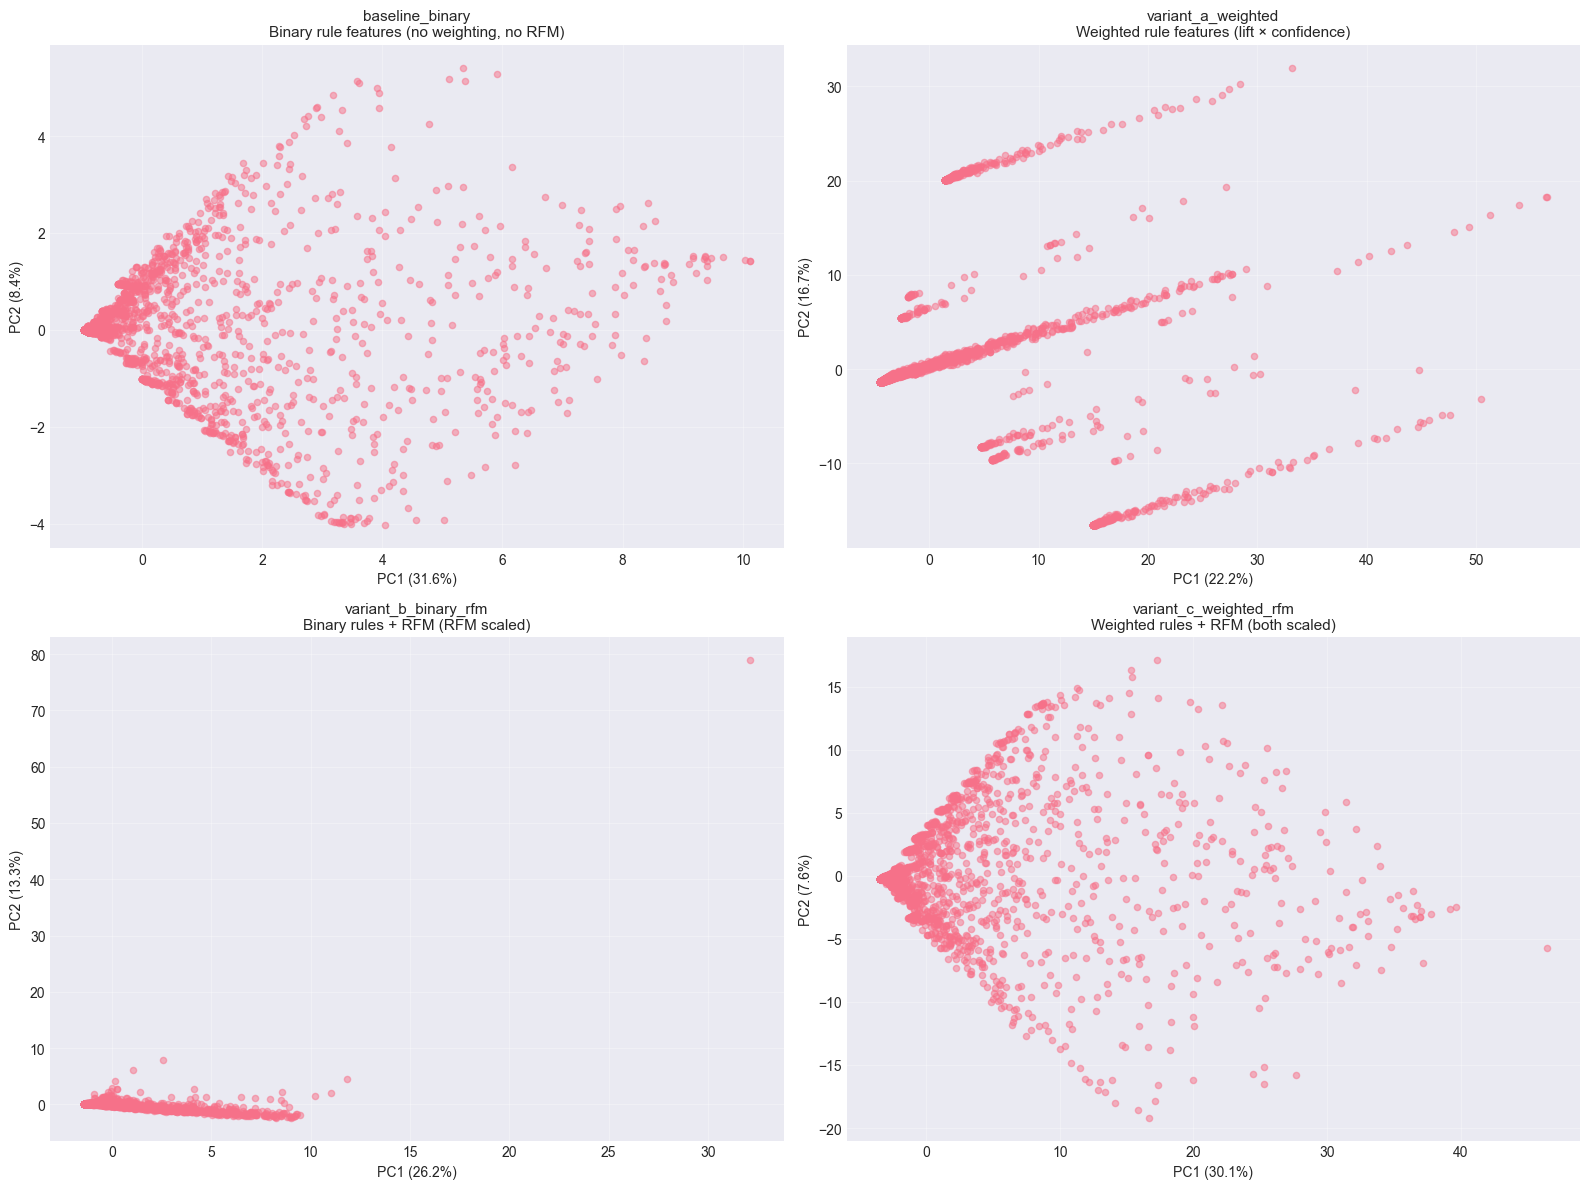

In [19]:
# PCA visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, variant) in enumerate(feature_variants.items()):
    data = variant['data'].values
    
    # PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)
    
    # Plot
    axes[idx].scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5, s=20)
    axes[idx].set_title(f"{name}\n{variant['description']}", fontsize=11)
    axes[idx].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    axes[idx].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Phân tích độ phân tán của các biến thể

In [20]:
# Tính các thống kê
stats_summary = []

for name, variant in feature_variants.items():
    data = variant['data'].values
    
    stats = {
        'Variant': name,
        'Shape': str(variant['data'].shape),
        'Mean': data.mean(),
        'Std': data.std(),
        'Min': data.min(),
        'Max': data.max(),
        'Sparsity (%)': (data == 0).sum() / data.size * 100,
        'Non-zero (%)': (data != 0).sum() / data.size * 100
    }
    stats_summary.append(stats)

stats_df = pd.DataFrame(stats_summary)
print("="*100)
print("THỐNG KÊ CÁC BIẾN THỂ ĐẶC TRƯNG")
print("="*100)
display(stats_df.round(4))

THỐNG KÊ CÁC BIẾN THỂ ĐẶC TRƯNG


,Variant,Shape,Mean,Std,Min,Max,Sparsity (%),Non-zero (%)
0,baseline_binary,"(3921, 175)",0.0689,0.2533,0.0000,1.0000,93.1120,6.8880
1,variant_a_weighted,"(3921, 175)",0.2847,1.3018,0.0000,20.8971,93.1120,6.8880
2,variant_b_binary_rfm,"(3921, 178)",0.0677,0.2828,-0.9163,60.3968,91.5427,8.4573
3,variant_c_weighted_rfm,"(3921, 178)",0.0000,0.9210,-0.9163,60.3968,15.1685,84.8315


## 13. Lưu các biến thể để sử dụng cho clustering

In [21]:
# Lưu từng biến thể
output_dir = Path("../data/features")
output_dir.mkdir(exist_ok=True)

for name, variant in feature_variants.items():
    output_path = output_dir / f"{name}.csv"
    variant['data'].to_csv(output_path)
    print(f"✓ Saved {name} to {output_path}")

# Lưu cấu hình
import json
config_path = output_dir / "feature_variants_config.json"
config_to_save = {
    name: {
        'description': variant['description'],
        'config': variant['config'],
        'shape': list(variant['data'].shape)
    }
    for name, variant in feature_variants.items()
}

with open(config_path, 'w') as f:
    json.dump(config_to_save, f, indent=2)
    
print(f"\n✓ Saved configuration to {config_path}")

✓ Saved baseline_binary to ..\data\features\baseline_binary.csv
✓ Saved variant_a_weighted to ..\data\features\variant_a_weighted.csv
✓ Saved variant_b_binary_rfm to ..\data\features\variant_b_binary_rfm.csv
✓ Saved variant_c_weighted_rfm to ..\data\features\variant_c_weighted_rfm.csv

✓ Saved configuration to ..\data\features\feature_variants_config.json


## 14. Tóm tắt các biến thể đã tạo

### Baseline - Binary Rule Features
- **Weighting**: Không
- **RFM**: Không
- **Scale Rules**: Không
- **Scale RFM**: Không áp dụng
- **Đặc điểm**: Đơn giản nhất, chỉ dựa vào việc khách hàng có thỏa antecedents hay không

### Variant A - Weighted Rule Features
- **Weighting**: Có (lift × confidence)
- **RFM**: Không
- **Scale Rules**: Không
- **Scale RFM**: Không áp dụng
- **Đặc điểm**: Phản ánh độ mạnh của luật, luật có lift và confidence cao sẽ đóng góp nhiều hơn

### Variant B - Binary Rules + RFM
- **Weighting**: Không
- **RFM**: Có
- **Scale Rules**: Không (giữ nhị phân 0/1)
- **Scale RFM**: Có (StandardScaler)
- **Đặc điểm**: Kết hợp pattern mua hàng với giá trị khách hàng

### Variant C - Weighted Rules + RFM
- **Weighting**: Có (lift × confidence)
- **RFM**: Có
- **Scale Rules**: Có (StandardScaler)
- **Scale RFM**: Có (StandardScaler)
- **Đặc điểm**: Tổng hợp đầy đủ nhất, cả độ mạnh luật và giá trị khách hàng

### Bước tiếp theo:
Áp dụng K-Means clustering trên từng biến thể và so sánh chất lượng cụm